In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

2024-07-22 10:43:40.195003: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps']
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps']

In [3]:
cnc_maps.shape

(86, 86, 1757)

In [6]:
# convert 3d numpy array to 2d numpy array
# the number of rows equal the number of cells 
cnc_maps_flatten = np.array([cnc_maps[:, :, i].flatten() for i in range(cnc_maps.shape[2])])

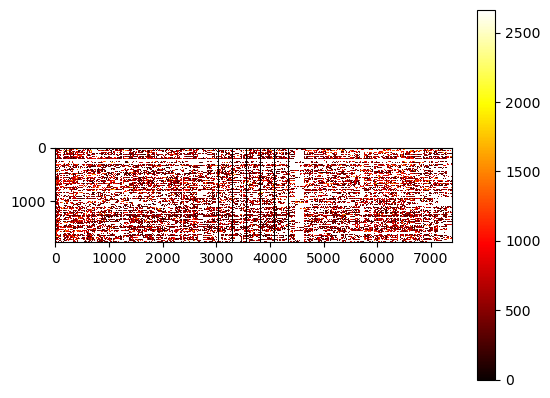

In [9]:
# visualize the flatten distance map
plt.imshow(cnc_maps_flatten, cmap='hot', interpolation='nearest')
plt.colorbar()

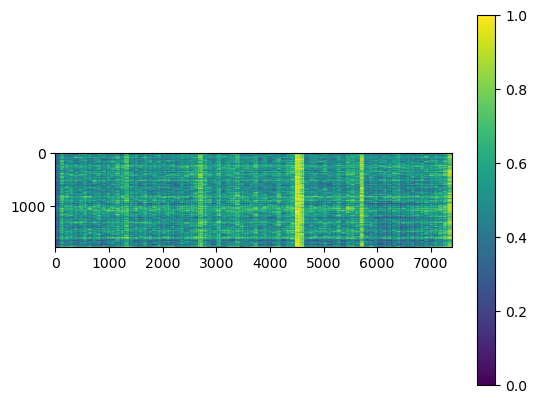

In [12]:
plt.imshow(np.isnan(cnc_maps_flatten))
plt.colorbar()

In [ ]:
# Idea: filling in the nan values from each barcode first so instead of (n_cells by n_probe^2) we can fill in (n_cells by n_probe)
# Lets try with simulated data

In [13]:
# Load the data from the dataset 
dataset_dir = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_10_1000_40.0_10000.pkl'

dataset_list, param_dict = load_dataset(dataset_dir)

In [14]:
template_list = dataset_list[0]['template_chain_list']
X = dataset_list[0]['observation_list']
label_list = dataset_list[0]['labels']

observations_flatten = [squareform(pdist(x)).flatten() for x in X]

# generate weight of each label from label_list
true_weights = np.array([np.sum(label_list == i) for i in np.unique(label_list)]) / len(label_list)
templates_flatten = [squareform(pdist(x)).flatten() for x in template_list]

# Generate random walk for guessing structures
num_monomers = param_dict['num_monomers']
mean_bond_length = param_dict['mean_bond_length']
std_bond_length = param_dict['std_bond_length'] 
num_templates = param_dict['num_templates']
measurement_error = param_dict['noise_std']
num_observations = param_dict['num_observations']
num_probes = num_monomers
num_candidates = num_templates

In [29]:
# Introducing missing data to the dataset at specific barcodes with some probabiliity between [0, 1]
missing_data_prob = np.random.normal(0.1, 0.5, num_monomers)
missing_data_prob[missing_data_prob < 0] = 0
missing_data_prob[missing_data_prob > 1] = 1


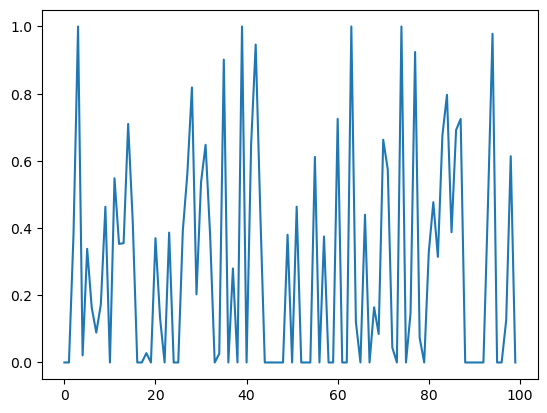

In [30]:
plt.plot(missing_data_prob)

In [35]:
# Get shuffle indices for shuffling dataset 
shuffle_indices = np.arange(num_observations)
np.random.shuffle(shuffle_indices)

In [36]:
observations_with_nan = np.array([squareform(pdist(x)) for x in X])
observations_with_nan = observations_with_nan[shuffle_indices, :, :]
# Randomly add nan to the dataset based on the missing_data_prob
for i in range(num_observations):
    missing_indices = np.random.uniform(size=num_monomers) < missing_data_prob
    observations_with_nan[i, missing_indices, :] = np.nan
    observations_with_nan[i, :, missing_indices] = np.nan

In [43]:
observations_flatten = np.array(observations_flatten)[shuffle_indices, :]

In [37]:
observations_flatten_with_nan = np.array([x.flatten() for x in observations_with_nan])

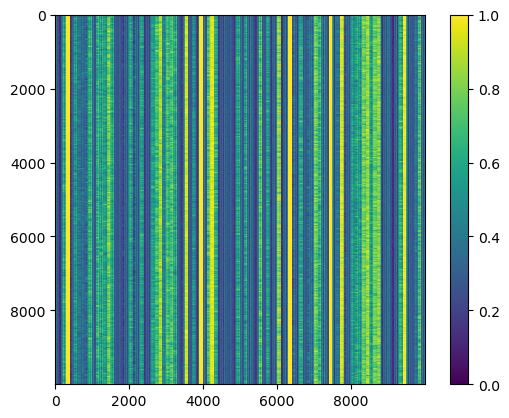

In [38]:
plt.imshow(np.isnan(observations_flatten_with_nan))
plt.colorbar()

In [44]:
# Then select the section of the distance between the first barcode and the remaining 
bc1_nan_map = observations_flatten_with_nan[:, :num_probes]

In [40]:
# Use Low Rank completion from pylop and pyproximal 
import pylops
import pyproximal 

In [45]:
bc1_map = observations_flatten[:, :num_probes]

In [62]:
# Define Restriction operator
sub = 0.4
ny, nx = bc1_map.shape
nsub = int(ny * nx * sub)
iava = np.random.permutation(np.arange(ny*nx))[:nsub]

Rop = pylops.Restriction(ny*nx, iava)

In [70]:
X = bc1_map

In [63]:
# Data 
y = Rop * bc1_map.ravel()

# Masked data 
Y = (Rop.H * Rop * bc1_map.ravel()).reshape(ny, nx)

In [117]:
Rop.H

<1000000x400000 _AdjointLinearOperator with dtype=float64>

In [61]:
iava

array([], dtype=int64)

In [64]:
Ux, Sx, Vhx = np.linalg.svd(bc1_map, full_matrices=False)

In [65]:
Uy, Sy, Vhy = np.linalg.svd(Y, full_matrices=False)

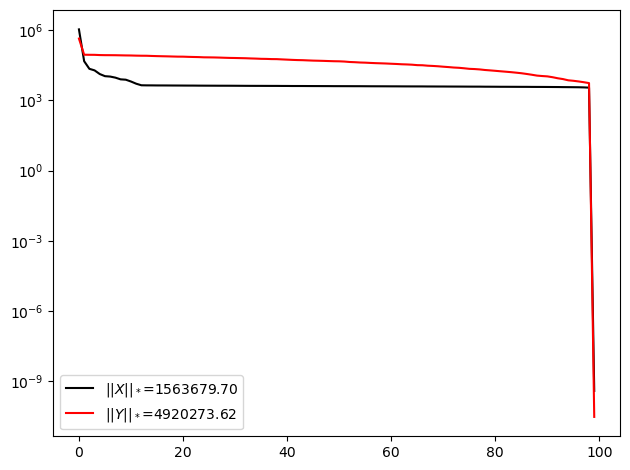

In [66]:
plt.figure()
plt.semilogy(Sx, 'k', label=r'$||X||_*$=%.2f' % np.sum(Sx))
plt.semilogy(Sy, 'r', label=r'$||Y||_*$=%.2f' % np.sum(Sy))
plt.legend()
plt.tight_layout()

In [67]:
mu = .8
f = pyproximal.L2(Rop, y)
g = pyproximal.Nuclear((ny, nx), mu)

Xpg = pyproximal.optimization.primal.ProximalGradient(f, g, np.zeros(ny*nx), acceleration='vandenberghe',
                                                      tau=1., niter=100, show=True)
Xpg = Xpg.reshape(ny, nx)

# Recompute SVD and see how the singular values look like
Upg, Spg, Vhpg = np.linalg.svd(Xpg, full_matrices=False)

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Nuclear.Nuclear'>
tau = 1.0	beta=5.000000e-01
epsg = 1.0	niter = 100
niterback = 100	acceleration = vandenberghe

   Itn       x[0]          f           g       J=f+eps*g       tau
     1   2.87120e-13   2.206e+01   3.936e+06   3.936e+06   1.000e+00
     2   2.41124e-12   2.206e+01   3.936e+06   3.936e+06   1.000e+00
     3   2.45515e-12   2.206e+01   3.936e+06   3.936e+06   1.000e+00
     4   2.48422e-12   2.206e+01   3.936e+06   3.936e+06   1.000e+00
     5   2.47275e-12   2.206e+01   3.936e+06   3.936e+06   1.000e+00
     6   2.40562e-12   2.206e+01   3.936e+06   3.936e+06   1.000e+00
     7   2.28080e-12   2.206e+01   3.936e+06   3.936e+06   1.000e+00
     8   2.10857e-12   2.206e+01   3.936e+06   3.936e+06   1.000e+00
     9   1.90497e-12   2.206e+01   3.936e+06   3.936e+06   1.000e+00


In [68]:
mu1 = 0.8 * np.sum(Sx)
g = pyproximal.proximal.NuclearBall((ny, nx), mu1)

Xpgc = pyproximal.optimization.primal.ProximalGradient(f, g, np.zeros(ny*nx), acceleration='vandenberghe',
                                                       tau=1., niter=100, show=True)
Xpgc = Xpgc.reshape(ny, nx)

# Recompute SVD and see how the singular values look like
Upgc, Spgc, Vhpgc = np.linalg.svd(Xpgc, full_matrices=False)

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Nuclear.NuclearBall'>
tau = 1.0	beta=5.000000e-01
epsg = 1.0	niter = 100
niterback = 100	acceleration = vandenberghe

   Itn       x[0]          f           g       J=f+eps*g       tau
     1   3.24802e-14   5.728e+10   1.000e+00   5.728e+10   1.000e+00
     2   8.28836e-13   3.031e+10   0.000e+00   3.031e+10   1.000e+00
     3   8.35211e-13   1.395e+10   1.000e+00   1.395e+10   1.000e+00
     4   6.85251e-13   5.633e+09   1.000e+00   5.633e+09   1.000e+00
     5   6.16360e-13   2.105e+09   1.000e+00   2.105e+09   1.000e+00
     6   5.91156e-13   8.576e+08   0.000e+00   8.576e+08   1.000e+00
     7   6.01722e-13   4.589e+08   1.000e+00   4.589e+08   1.000e+00
     8   6.20859e-13   3.041e+08   0.000e+00   3.041e+08   1.000e+00
     9   6.37196e-13   2.218e+08   0.000e+00   2.218e+08   1.000e

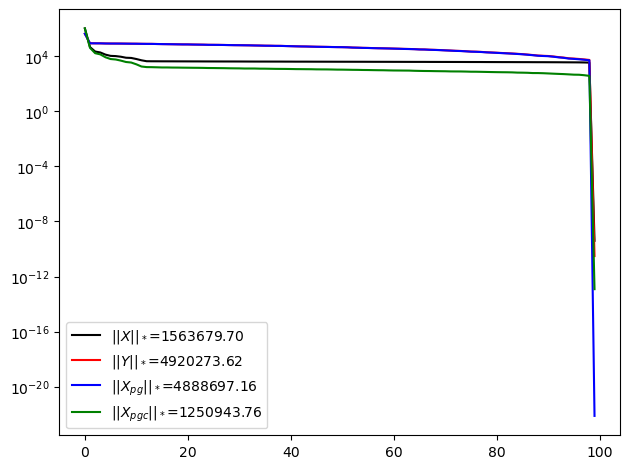

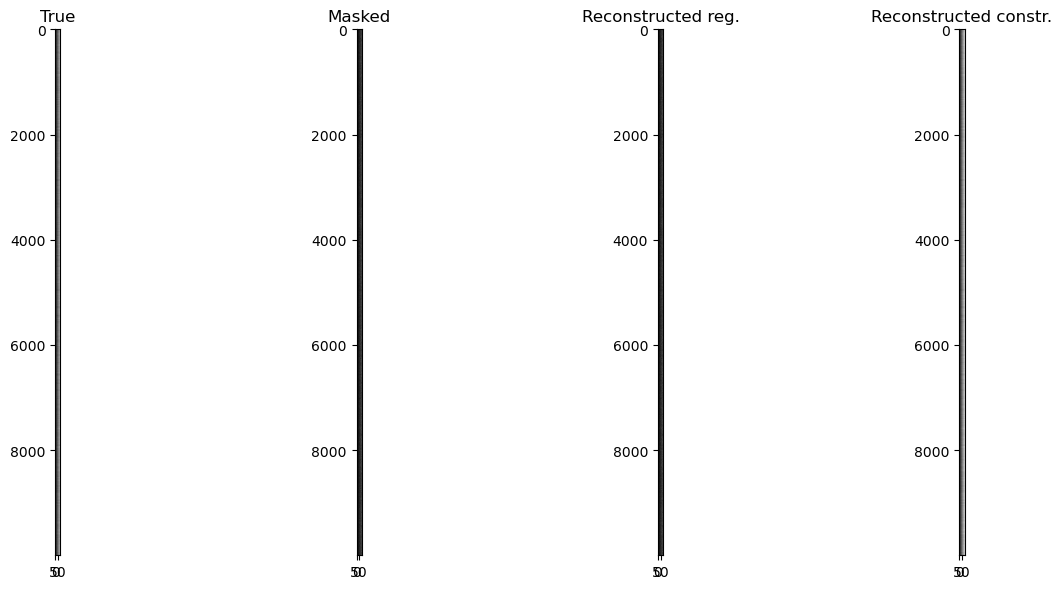

In [71]:
plt.figure()
plt.semilogy(Sx, 'k', label=r'$||X||_*$=%.2f' % np.sum(Sx))
plt.semilogy(Sy, 'r', label=r'$||Y||_*$=%.2f' % np.sum(Sy))
plt.semilogy(Spg, 'b', label=r'$||X_{pg}||_*$=%.2f' % np.sum(Spg))
plt.semilogy(Spgc, 'g', label=r'$||X_{pgc}||_*$=%.2f' % np.sum(Spgc))
plt.legend()
plt.tight_layout()

fig, axs = plt.subplots(1, 4, figsize=(14, 6))
axs[0].imshow(X, cmap='gray')
axs[0].set_title('True')
axs[1].imshow(Y, cmap='gray')
axs[1].set_title('Masked')
axs[2].imshow(Xpg, cmap='gray')
axs[2].set_title('Reconstructed reg.')
axs[3].imshow(Xpgc, cmap='gray')
axs[3].set_title('Reconstructed constr.')
fig.tight_layout()

In [74]:
np.linalg.norm(X - Y)

823601.3450547147

In [73]:
np.linalg.norm(X - Xpg)

818744.8457266534

In [72]:
np.linalg.norm(X - Xpgc)

39398.886913824776

In [77]:
Y[0, :]

array([   0.        ,   66.84759683,    0.        ,   89.04196057,
          0.        ,    0.        ,  160.86866709,    0.        ,
          0.        ,  257.7687408 ,    0.        ,    0.        ,
          0.        ,  226.1722015 ,    0.        ,    0.        ,
        368.05356941,    0.        ,    0.        ,    0.        ,
          0.        ,  325.76796881,    0.        ,  466.02277829,
        420.75106646,  553.66120907,    0.        ,  454.87132785,
          0.        ,  522.49049817,    0.        ,  667.70528285,
        630.72061097,    0.        ,  564.53444731,  651.57533614,
          0.        ,  703.86864705,    0.        ,    0.        ,
        745.12820375,    0.        ,  769.32711621,  766.05089913,
          0.        ,  852.37430148,    0.        ,    0.        ,
          0.        ,    0.        , 1036.71153836,    0.        ,
          0.        , 1031.68611587,    0.        ,    0.        ,
       1110.76900195,    0.        , 1089.45063545, 1066.61509

In [88]:
Y[0, Y[0, :] == 0] = np.nan
Y[0, 0] = 0

In [112]:
Y[0,  np.isnan(Y[0, :])] = 0

In [103]:
nan_array = Y[0, :].copy()

In [104]:
nan_indices = []
for i, x in enumerate(nan_array):
    if np.isnan(x):
        nan_indices.append(i)
    else:
        if not nan_indices:
            prev_exist = x
        else:
            diff = (x - prev_exist) / (len(nan_indices)+1)
            for k, j in enumerate(nan_indices):
                nan_array[j] = prev_exist + diff*(k+1)
            prev_exist = x
            nan_indices = []
        

In [105]:
nan_array 

array([   0.        ,   66.84759683,   77.9447787 ,   89.04196057,
        112.98419607,  136.92643158,  160.86866709,  193.16869166,
        225.46871623,  257.7687408 ,  249.86960598,  241.97047115,
        234.07133632,  226.1722015 ,  273.4659908 ,  320.75978011,
        368.05356941,  359.59644929,  351.13932917,  342.68220905,
        334.22508893,  325.76796881,  395.89537355,  466.02277829,
        420.75106646,  553.66120907,  504.26626846,  454.87132785,
        488.68091301,  522.49049817,  595.09789051,  667.70528285,
        630.72061097,  597.62752914,  564.53444731,  651.57533614,
        677.7219916 ,  703.86864705,  717.62183262,  731.37501818,
        745.12820375,  757.22765998,  769.32711621,  766.05089913,
        809.21260031,  852.37430148,  889.24174886,  926.10919623,
        962.97664361,  999.84409099, 1036.71153836, 1035.03639753,
       1033.3612567 , 1031.68611587, 1058.0470779 , 1084.40803992,
       1110.76900195, 1100.1098187 , 1089.45063545, 1066.61509

In [106]:
def mean_inputation(nan_2d_array):
    result = nan_2d_array.copy()
    for i in range(nan_2d_array.shape[0]):
        nan_indices = []
        for z, x in enumerate(nan_2d_array[i, :]):
            if x == 0 and z > 0:
                nan_indices.append(z)
            else:
                if not nan_indices:
                    prev_exist = x
                else:
                    diff = (x - prev_exist) / (len(nan_indices)+1)
                    for k, j in enumerate(nan_indices):
                        result[i, j] = prev_exist + diff*(k+1)
                    prev_exist = x
                    nan_indices = []
    return result

In [113]:
X_mi = mean_inputation(Y)

In [114]:
X_mi[0, :]

array([   0.        ,   66.84759683,   77.9447787 ,   89.04196057,
        112.98419607,  136.92643158,  160.86866709,  193.16869166,
        225.46871623,  257.7687408 ,  249.86960598,  241.97047115,
        234.07133632,  226.1722015 ,  273.4659908 ,  320.75978011,
        368.05356941,  359.59644929,  351.13932917,  342.68220905,
        334.22508893,  325.76796881,  395.89537355,  466.02277829,
        420.75106646,  553.66120907,  504.26626846,  454.87132785,
        488.68091301,  522.49049817,  595.09789051,  667.70528285,
        630.72061097,  597.62752914,  564.53444731,  651.57533614,
        677.7219916 ,  703.86864705,  717.62183262,  731.37501818,
        745.12820375,  757.22765998,  769.32711621,  766.05089913,
        809.21260031,  852.37430148,  889.24174886,  926.10919623,
        962.97664361,  999.84409099, 1036.71153836, 1035.03639753,
       1033.3612567 , 1031.68611587, 1058.0470779 , 1084.40803992,
       1110.76900195, 1100.1098187 , 1089.45063545, 1066.61509

In [115]:
np.linalg.norm(X-X_mi)

220134.5744236236

In [ ]:
# Constraint matrix imputation did a better job that a simple mean imputation
# Lets test this more systematically 